# Домашнее задание по ML №1

Результат выполнения задания — это отчёт в формате html на основе Jupyter Notebook. Нормальный отчёт должен включать в себя:

* Краткую постановку задачи и формулировку задания
* Описание минимума необходимой теории и/или описание используемых инструментов - не стоит переписывать лекции или Википедию
* Подробный пошаговый рассказ о проделанной работе
* Аккуратно оформленные результаты
* Внятные выводы – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

## Задачи:

1. Проверить, получается ли восстановить кластерную структуру новостей, то есть, разделить их на 28 кластеров, соответствущих событиям.
2. Проверить, получается ли использовать кластерный анализ для обобщения.

## Импортируем библиотеки

Для успешной работы с данными должны быть установлены следующие библиотеки:

* numpy
* pandas
* sklearn
* sklearn
* nltk
* pymystem3 (для качественной лемматизации)
* matplotlib
* seaborn

Проект сделан в Python3.

In [138]:
# coding: utf-8

import re
import numpy as np
import pandas as pd
from nltk import word_tokenize
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


from sklearn.cluster import KMeans

import seaborn as sns

%matplotlib inline

## Часть 1. Предварительная обработка текстов

Проведите предобработку новостей: токенизацию, приведение к нижнему регистру, лемматизацию. Проверьте, есть ли в коллекции дубликаты. Посчитайте, сколько новостей относится к каждому резонансному событию.

In [139]:
# Загрузили данные
df_events = pd.read_csv('events.csv')
df_news = pd.read_csv('raw_news.csv', index_col='id')

In [140]:
print(df_events.head())

   id               date                                               name
0   1  01/10/17 12:00 AM  Власти Петербурга согласились передать РПЦ Иса...
1   2  01/20/17 12:00 AM  Дональд Трамп вступил в должность президента США.
2   3  02/20/17 12:00 AM  Скоропостижно скончался постпред России при ОО...
3   4  03/02/17 12:00 AM           Вышел фильм Навального «он Вам не димон»
4   5  03/14/17 12:00 AM  CNN показала фильм «Владимир Путин — самый вли...


In [141]:
print(df_news.head())

    event_id                                               text
id                                                             
0          1   В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...
1          1   Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...
2          1   Аргументы и Факты (aif.ru), Москва, 14 января...
3          1   Google Новости ТОП, Москва, 14 января 2017 АК...
4          1   Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...


In [142]:
# Загрузили стопслова для русского языка
stopset = stopwords.words('russian') # Саш, я переименовала эту переменную, потому что она перезаписывала модуль
print(stopset[:10])

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']


In [149]:
# Токенизация, лемматизация
m = Mystem()
def tokenize(text, stopset):
    arr = []
    text = [re.sub('[!"?/\\().:;,-]', '', msg) for msg in text] # убрали знаки препинания
    text = [' '.join(m.lemmatize(msg.lower())) for msg in text] # лемматизировали и привели к нижнему регистру
    text = [[w for w in word_tokenize(msg) if not w in stopset] for msg in text] # токенизировали и избавились от стоп слов
    for msg in text:
        arr.append(' '.join(msg))
    return arr # возвращаю массив стрингов. каждый стринг --- это один документ

In [150]:
print(df_news['text'][:10])

id
0     В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...
1     Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...
2     Аргументы и Факты (aif.ru), Москва, 14 января...
3     Google Новости ТОП, Москва, 14 января 2017 АК...
4     Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...
5     Top Real Estate (topre.ru), Москва, 13 января...
6     Findnews.ru, Москва, 13 января 2017 ПОЛИЦИЯ Н...
7     ПРАВДА.info (pravda.info), Москва, 13 января ...
8     Голос Америки (golos-ameriki.ru), Москва, 13 ...
9     Выбор Народа (vybor-naroda.org), Москва, 13 я...
Name: text, dtype: object


In [151]:
print(tokenize(df_news['text'][:10], stopset))

['петербург проходить митинг против передача исаакиевский собор рпц санктпетербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какуюлибо символика плакат также мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник который заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санктпетербург предоставлять право встречаться избиратель встреча проводить рассказывать защищать интерес передача собор сказать парламентарий свой очередь директор музей исаакиевский собо

In [152]:
df_news['text'] = tokenize(df_news['text'], stopset) # перезаписали столбец в датасете
print(df_news.head())

    event_id                                               text
id                                                             
0          1  петербург проходить митинг против передача иса...
1          1  lentaco москва 14 январь 2017 ситуация передач...
2          1  аргумент факт aifru москва 14 январь 2017 оппо...
3          1  google новость топ москва 14 январь 2017 акция...
4          1  газетаru москва 13 январь 2017 московский патр...


In [153]:
print(df_news.groupby('event_id').describe())

          text                                                               
         count unique                                                top freq
event_id                                                                     
1          100    100  суть событие argumentirucom москва 13 январь 2...    1
2           51     51  russia today russianrtcom москва 21 январь 201...    1
3           84     84  top real estate topreru москва 21 февраль 2017...    1
4           62     62  телеканал дождь tvrainru москва 3 март 2017 фб...    1
5            2      2  cnn владимир путин самый могущественный челове...    1
6           41     41  агентство федеральный расследование flbru моск...    1
7          100    100  новость день novostidnyru москва 23 март 2017 ...    1
8           27     27  новость @ ramblerru москва 23 март 2017 европа...    1
9           82     76  коммерсант новость информ центр москва 23 март...    2
10         100    100  wordyouru москва 27 март 2017 митинг моск

Выше мы посчитала кол-во новостей для каждого события.В 9-м резонансном событии уникальных новостей меньше, чем их общее кол-во. Отсюда следуюет -- дубликаты в девятом резонансном событии.

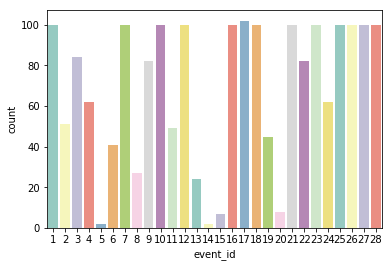

In [154]:
sns.countplot(x=df_news['event_id'], data=df_news, palette="Set3")

Из представленного выше графика видно, что данные неоднородны.

## Часть 2. Кластеризация текстов

Любым известным вам алгоритмом найдите в коллекции новостей 28 кластеров. Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте любые известные вам меры качества для оценки качества кластеризации. Покажите, как $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество кластеризации.

### Tf-idf преобразование